In [1]:
# Importing the necessary libraries 
# Installing prophet on macos - https://gist.github.com/thewisenerd/52f937d01b06287ccf21a05a118e74ad
# pandas version pd.__version__

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]


In [2]:
# Putting the measurement files in a list for easy processing 
pfiles = ["./RIPE-Atlas-measurement-48819905.json","./RIPE-Atlas-measurement-48819907.json","./RIPE-Atlas-measurement-48819909.json","./RIPE-Atlas-measurement-48819911.json","./RIPE-Atlas-measurement-48819913.json"]

In [3]:
# Merging the ping measurement files 
# https://stackoverflow.com/questions/57422734/how-to-merge-multiple-json-files-into-one-file-in-python

def merge_JsonFiles(filename):
    result = list()
    for f1 in filename:
        with open(f1, 'r') as infile:
            result.extend(json.load(infile))

    with open('mergedJson.json', 'w') as output_file:
        json.dump(result, output_file)

merge_JsonFiles(pfiles)


In [4]:
# Putting the merged files into a dataframe - preparing the data for forecasting
df = pd.read_json("./mergedJson.json")
df

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,avg,msm_id,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,14.612530,48819905,1003454,2023-01-16 10:13:25,Ping,51.15.99.8,ping,48819905,300,1673864050
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,24.125096,48819905,1003747,2023-01-16 10:13:23,Ping,45.137.88.145,ping,48819905,300,1673864114
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,22.542065,48819905,20757,2023-01-16 10:13:11,Ping,82.116.160.225,ping,48819905,300,1673864089
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,26.183208,48819905,53229,2023-01-16 10:13:39,Ping,83.54.157.101,ping,48819905,300,1673864090
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,171.458986,48819905,51381,2023-01-16 10:14:34,Ping,102.34.0.4,ping,48819905,300,1673864205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28170,5040,2.4.1,3,52.46.200.93,4,52.46.200.93,192.168.1.3,ICMP,235.0,64,...,68.508421,48819913,1004102,2023-01-18 09:09:59,Ping,149.90.236.149,ping,48819913,300,1674033077
28171,5040,2.4.1,2,52.46.200.93,4,52.46.200.93,192.168.168.209,ICMP,221.0,64,...,70.749029,48819913,1004200,2023-01-18 09:09:51,Ping,88.24.68.105,ping,48819913,300,1674033051
28172,5080,2.6.2,67,52.46.200.93,4,52.46.200.93,192.168.1.38,ICMP,220.0,64,...,56.019584,48819913,53229,2023-01-18 09:09:21,Ping,83.54.157.101,ping,48819913,300,1674033081
28173,5040,2.4.1,49,52.46.200.93,4,52.46.200.93,10.18.246.209,ICMP,231.0,64,...,19.059942,48819913,1003454,2023-01-18 09:10:09,Ping,51.15.99.8,ping,48819913,300,1674033100


In [5]:
# Cleaning the data 

# Checking the negative values - possible time out ???
df_test = df[df['avg']<0]
df_test.groupby(['prb_id','dst_addr']).count()

# Change them to NaN
df['avg'].replace(-1.0, np.nan, inplace=True)

# Checking for null values in each column
df_null = df['avg'].isnull().sum()
df_null

# Remove Null values 
df = df.dropna(how='any',axis=0) 
df.shape

(27932, 26)

In [6]:
# Renaming the probe_id column for easy plotting 
nprb_id = []

for value in df["prb_id"]:
    if value == 1004991:
        nprb_id.append('es1')
    if value == 53229:
        nprb_id.append('es2')
    if value == 1004997:
        nprb_id.append("pt1")
    if value == 1004102:
        nprb_id.append("pt2")
    if value == 20757:
        nprb_id.append("es3")
    if value ==1003454:
        nprb_id.append("nl1")
    if value == 1003158:
        nprb_id.append("nl2")
    if value == 1003747:
        nprb_id.append("nl3")
    if value == 1004200:
        nprb_id.append("es4")
    if value == 51381:
        nprb_id.append("ug1")
    if value == 54470:
        nprb_id.append("us1")
    if value == 1002914:
        nprb_id.append("us2")
        
        
df["nprb_id"] = nprb_id
df

/var/folders/fn/t1h5mchj4qg8nfdt2p1xfmwh0000gn/T/ipykernel_4392/2807815070.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["nprb_id"] = nprb_id


,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,msm_id,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,48819905,1003454,2023-01-16 10:13:25,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,48819905,1003747,2023-01-16 10:13:23,Ping,45.137.88.145,ping,48819905,300,1673864114,nl3
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,48819905,20757,2023-01-16 10:13:11,Ping,82.116.160.225,ping,48819905,300,1673864089,es3
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,48819905,53229,2023-01-16 10:13:39,Ping,83.54.157.101,ping,48819905,300,1673864090,es2
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,48819905,51381,2023-01-16 10:14:34,Ping,102.34.0.4,ping,48819905,300,1673864205,ug1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28170,5040,2.4.1,3,52.46.200.93,4,52.46.200.93,192.168.1.3,ICMP,235.0,64,...,48819913,1004102,2023-01-18 09:09:59,Ping,149.90.236.149,ping,48819913,300,1674033077,pt2
28171,5040,2.4.1,2,52.46.200.93,4,52.46.200.93,192.168.168.209,ICMP,221.0,64,...,48819913,1004200,2023-01-18 09:09:51,Ping,88.24.68.105,ping,48819913,300,1674033051,es4
28172,5080,2.6.2,67,52.46.200.93,4,52.46.200.93,192.168.1.38,ICMP,220.0,64,...,48819913,53229,2023-01-18 09:09:21,Ping,83.54.157.101,ping,48819913,300,1674033081,es2
28173,5040,2.4.1,49,52.46.200.93,4,52.46.200.93,10.18.246.209,ICMP,231.0,64,...,48819913,1003454,2023-01-18 09:10:09,Ping,51.15.99.8,ping,48819913,300,1674033100,nl1


In [7]:
# Changing the time column from epoch to date time format for time series processing 
new_timestamp = []

for i in df['stored_timestamp']:
    my_datetime = datetime.fromtimestamp(i)
    new_timestamp.append(my_datetime)

df2 = df.copy()
df2['new_time'] = new_timestamp
df2

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,1003454,2023-01-16 10:13:25,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1,2023-01-16 11:14:10
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,1003747,2023-01-16 10:13:23,Ping,45.137.88.145,ping,48819905,300,1673864114,nl3,2023-01-16 11:15:14
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,20757,2023-01-16 10:13:11,Ping,82.116.160.225,ping,48819905,300,1673864089,es3,2023-01-16 11:14:49
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,53229,2023-01-16 10:13:39,Ping,83.54.157.101,ping,48819905,300,1673864090,es2,2023-01-16 11:14:50
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,51381,2023-01-16 10:14:34,Ping,102.34.0.4,ping,48819905,300,1673864205,ug1,2023-01-16 11:16:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28170,5040,2.4.1,3,52.46.200.93,4,52.46.200.93,192.168.1.3,ICMP,235.0,64,...,1004102,2023-01-18 09:09:59,Ping,149.90.236.149,ping,48819913,300,1674033077,pt2,2023-01-18 10:11:17
28171,5040,2.4.1,2,52.46.200.93,4,52.46.200.93,192.168.168.209,ICMP,221.0,64,...,1004200,2023-01-18 09:09:51,Ping,88.24.68.105,ping,48819913,300,1674033051,es4,2023-01-18 10:10:51
28172,5080,2.6.2,67,52.46.200.93,4,52.46.200.93,192.168.1.38,ICMP,220.0,64,...,53229,2023-01-18 09:09:21,Ping,83.54.157.101,ping,48819913,300,1674033081,es2,2023-01-18 10:11:21
28173,5040,2.4.1,49,52.46.200.93,4,52.46.200.93,10.18.246.209,ICMP,231.0,64,...,1003454,2023-01-18 09:10:09,Ping,51.15.99.8,ping,48819913,300,1674033100,nl1,2023-01-18 10:11:40


In [8]:
df2.to_pickle('df_timeseries.pickle')

In [9]:
#  Grouping results by probe_id then destination 
df2.groupby(['nprb_id','dst_addr']).count()


fw  mver  lts  dst_name   af  src_addr  proto  ttl  \
nprb_id dst_addr                                                             
es1     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
es2     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
es3     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
es4     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
nl1     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
nl3     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       564  564       564    564  564   
pt2     52.46.200.93   556   556  556       556  556       556    556  556   
        52.46.72.50    556   556  556       556  556       556    556  556   
        52.94.56.52    555   555  555       555  555       555    555  555   
        54.239.55.167  555   555  555       555  555       555    555  555   
        67.220.226.67  555   555  555       555  555       555    555  555   
ug1     52.46.200.93   520   520  520       520  520       520    520  520   
        52.46.72.50    521   521  521       521  521       521    521  521   
        52.94.56.52    521   521  521       521  521       521    521  521   
        54.239.55.167  521   521  521       521  521       521    521  521   
        67.220.226.67  520   520  520       520  520       520    520  520   
us1     52.46.200.93   563   563  563       563  563       563    563  563   
        52.46.72.50    562   562  562       562  562       562    562  562   
        52.94.56.52    562   562  562       562  562       562    562  562   
        54.239.55.167  563   563  563       563  563       563    563  563   
        67.220.226.67  562   562  562       562  562       562    562  562   
us2     52.46.200.93   564   564  564       564  564       564    564  564   
        52.46.72.50    564   564  564       564  564       564    564  564   
        52.94.56.52    564   564  564       564  564       564    564  564   
        54.239.55.167  564   564  564       564  564       564    564  564   
        67.220.226.67  564   564  564       56

In [10]:
# Extracting the results of one probe and destination
dfprbdtn = df2[(df2['nprb_id'] == 'es1') & (df2['dst_addr'] == "52.46.200.93")]
dfprbdtn


,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time
22549,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-16 10:15:30,Ping,18.100.6.236,ping,48819913,300,1673864259,es1,2023-01-16 11:17:39
22559,5080,2.6.2,49,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-16 10:20:34,Ping,18.100.6.236,ping,48819913,300,1673864518,es1,2023-01-16 11:21:58
22569,5080,2.6.2,39,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-16 10:25:41,Ping,18.100.6.236,ping,48819913,300,1673864814,es1,2023-01-16 11:26:54
22579,5080,2.6.2,48,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-16 10:30:41,Ping,18.100.6.236,ping,48819913,300,1673865112,es1,2023-01-16 11:31:52
22589,5080,2.6.2,0,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-16 10:35:42,Ping,18.100.6.236,ping,48819913,300,1673865422,es1,2023-01-16 11:37:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28134,5080,2.6.2,42,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-18 08:50:40,Ping,18.100.6.236,ping,48819913,300,1674031922,es1,2023-01-18 09:52:02
28144,5080,2.6.2,43,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-18 08:55:37,Ping,18.100.6.236,ping,48819913,300,1674032203,es1,2023-01-18 09:56:43
28154,5080,2.6.2,35,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-18 09:00:37,Ping,18.100.6.236,ping,48819913,300,1674032511,es1,2023-01-18 10:01:51
28164,5080,2.6.2,49,52.46.200.93,4,52.46.200.93,172.31.6.130,ICMP,224.0,64,...,1004991,2023-01-18 09:05:38,Ping,18.100.6.236,ping,48819913,300,1674032810,es1,2023-01-18 10:06:50


Text(0.5, 1.0, 'Round trip time Vs Time ')

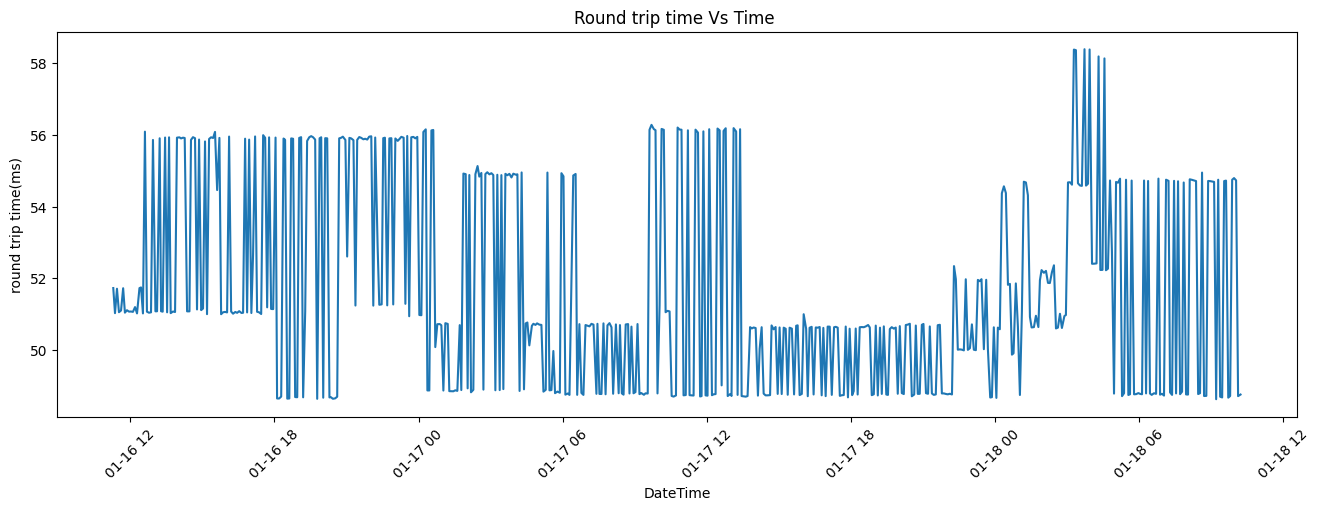

In [11]:
# Visualising the distribution of rtt 
plt.plot(dfprbdtn["new_time"],dfprbdtn["avg"])
plt.ylabel("round trip time(ms)")
plt.xlabel("DateTime")
plt.xticks(rotation=45)
plt.title("Round trip time Vs Time ")

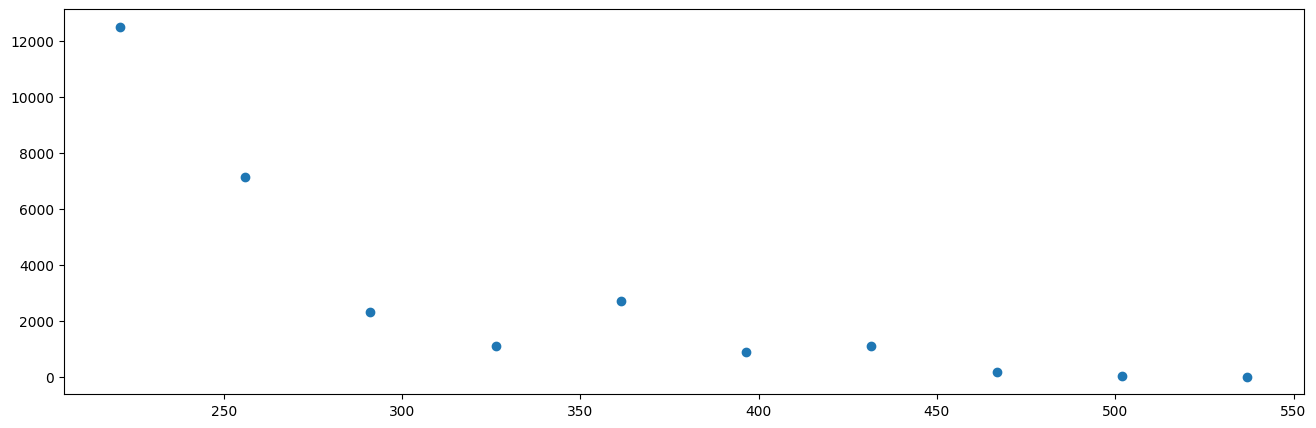

In [12]:
# Visualising the cumulative distribution of the whole population
# https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
# https://www.youtube.com/watch?v=a7pi68qu8-g

stats_df = df.copy()

# Using numpy to plot histogram - get bins and edges first
c,e = np.histogram(stats_df['avg'])

#using the center of the bins for plotting 
b = (e[1:]+e[-1]/2)

#plot 
plt.scatter(b,c)

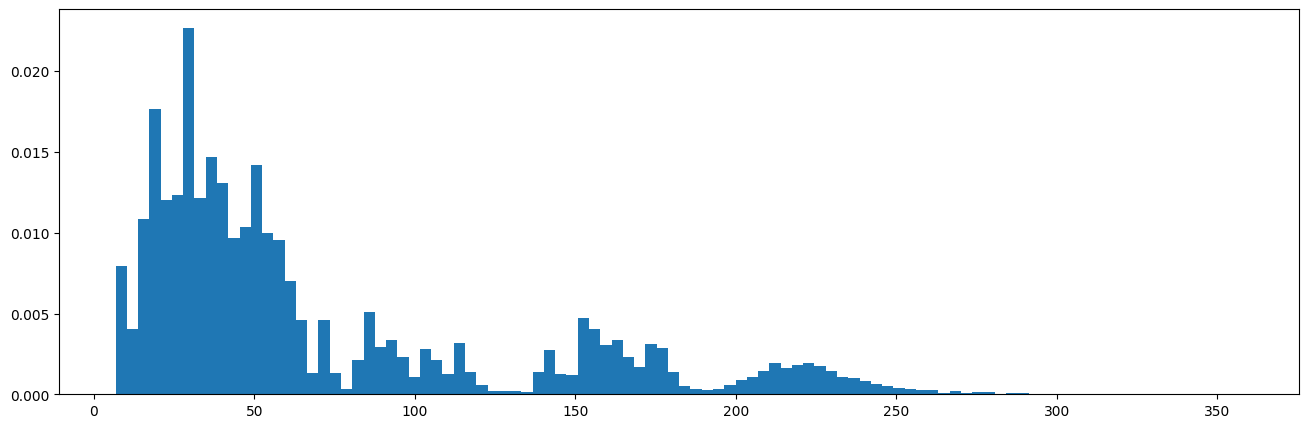

In [13]:
# Using matplotlib to plot histograms.
# Add density to normalise
c = plt.hist(stats_df['avg'],bins = 100,density = True)

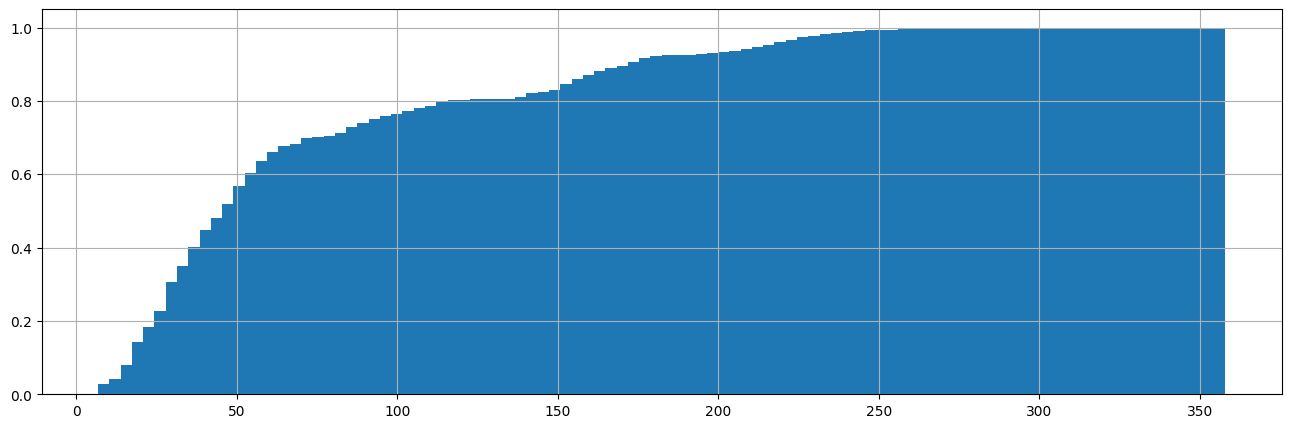

In [14]:
stats_df['avg'].hist(cumulative=True, density=True, bins=100)
plt.show()

<AxesSubplot: xlabel='avg'>

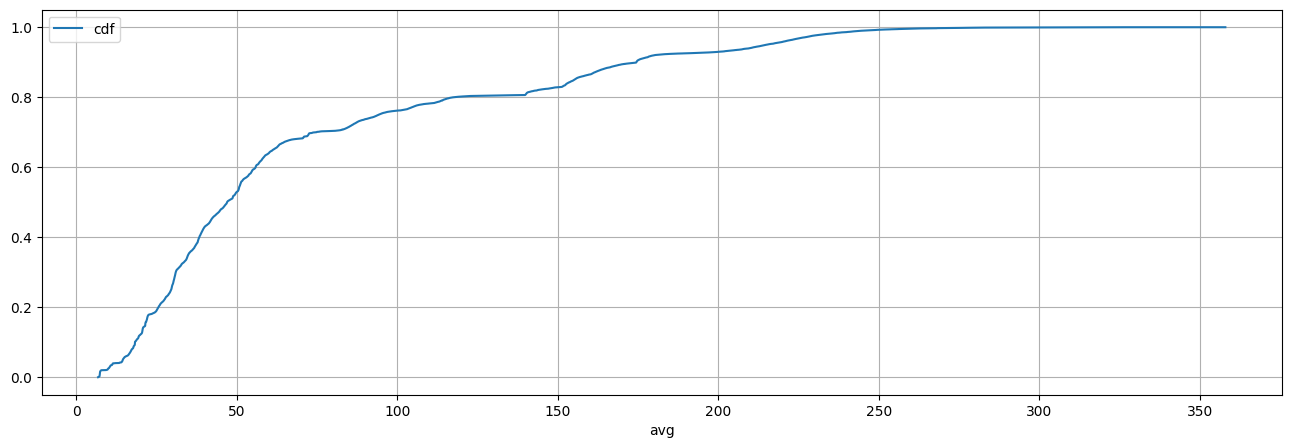

In [15]:
# Cumulative Density Function using ranking 

stats_df['cdf'] = stats_df['avg'].rank(method = 'average', pct = True,ascending= True)
stats_df.sort_values('avg').plot(x = 'avg', y = 'cdf', grid = True)

In [16]:
stats_df = stats_df.groupby('avg')['avg'].agg('count').pipe(pd.DataFrame).rename(columns = {'avg': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])


# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df


,avg,frequency,pdf,cdf
0,6.788467,1,0.000036,0.000036
1,6.836835,1,0.000036,0.000072
2,6.857500,1,0.000036,0.000107
3,6.868480,1,0.000036,0.000143
4,6.874784,1,0.000036,0.000179
...,...,...,...,...
27923,316.481556,1,0.000036,0.999857
27924,316.769938,1,0.000036,0.999893
27925,320.050792,1,0.000036,0.999928
27926,326.558945,1,0.000036,0.999964


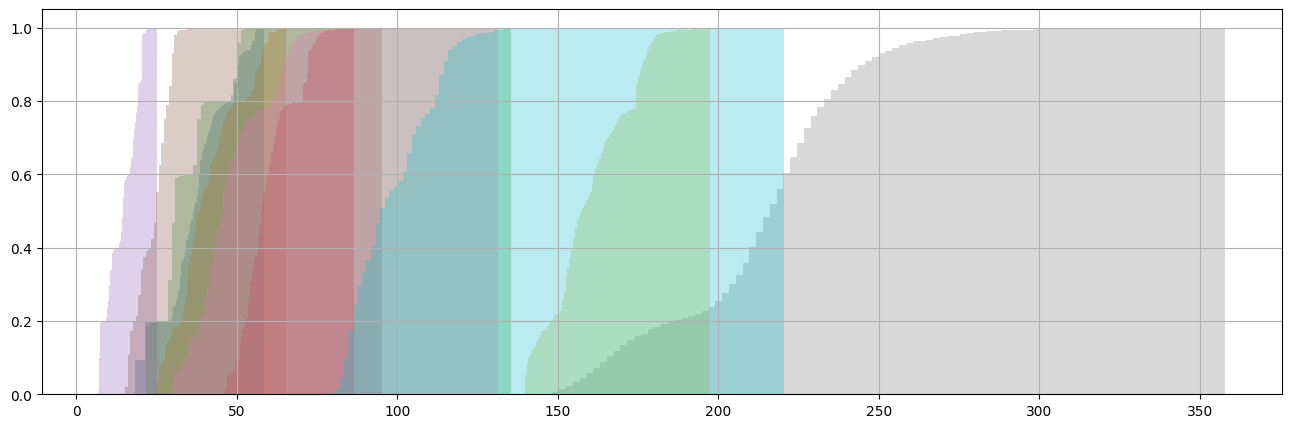

In [17]:
#checking cdf for each of the probes
probes = ['es1','es2','es3','es4','nl1','nl3','pt2','ug1','us1','us2']

for probe in probes:
    df_cdf = df2[(df2['nprb_id'] == probe)]
    df_cdf['avg'].hist(cumulative=True, density=True, bins=100,label= probe,alpha=0.3)